In [1]:
from google.colab import drive;
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

# Set up Kaggle credentials
if not os.path.exists('~/.kaggle/kaggle.json'):
    !mkdir -p ~/.kaggle
    !cp '/content/drive/MyDrive/kaggle.json' ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json # r, w
    print('Kaggle credentials have been set up.')
else:
    print('Kaggle credentials already exist, skipping setup.')

# Download dataset if not already downloaded
if not os.path.exists('har-competition.zip'):
    !kaggle datasets download yeegaureofficial/har-competition
    print('Dataset downloaded.')
else:
    print('Dataset already exists, skipping download.')

# Unzip dataset if not already unzipped
if not os.path.exists('/content/har-competition'):
    !unzip har-competition.zip -d /content/har-competition
    print('Files do not exist, these files have been unzipped.')
else:
    print('Directory already exists, skipping unzipping process.')

!ls /content/har-competition

Kaggle credentials have been set up.
Dataset already exists, skipping download.
Directory already exists, skipping unzipping process.
activity_labels.csv  features_info.txt	features.txt  README.txt  testX.csv  trainYX.csv


In [3]:
import numpy as np, pandas as pd, time, random

import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchsummary import summary

class Timer:
    def __init__(self):
        self.start_time = None
        self.end_time = None

    def start(self):
        self.start_time = time.time()
        print('timer started ⏳')

    def stop(self):
        self.end_time = time.time()
        time_elapsed = self.end_time - self.start_time
        print(f'time elapsed: {time_elapsed: .4f} seconds')

In [4]:
def set_seed(seed: int=42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    print(f'random seed set as {seed}')

set_seed(42)

random seed set as 42


In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('CUDA activated')
else:
    device = torch.device('cpu')
    print('CPU activated')

CUDA activated


In [6]:
tmr = Timer()
tmr.start()

timer started ⏳


### Create DataFrame

In [7]:
X_test = pd.read_csv('har-competition/testX.csv', index_col='id')
YX_train = pd.read_csv('har-competition/trainYX.csv')

In [8]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
id,,,,,,,,,,,,,,,,,,,,,
0,0.3142,-0.0251,-0.1250,-0.4185,-0.1707,-0.4265,-0.4497,-0.1836,-0.4100,-0.1537,...,0.0124,-0.2009,-0.6180,-0.5780,0.7380,-0.9350,-0.2076,-0.6700,0.3171,0.0052
1,0.2496,-0.0210,-0.0990,-0.9480,-0.9590,-0.9790,-0.9614,-0.9660,-0.9840,-0.9120,...,0.3090,-0.0421,-0.4000,-0.0448,0.1063,0.3752,0.2942,0.5903,-0.4210,-0.5990
2,0.2730,-0.0185,-0.1048,-1.0010,-1.0000,-0.9920,-0.9937,-0.9700,-0.9810,-0.9434,...,0.1108,-0.5625,-0.8535,-0.0736,-0.0179,-0.6567,0.5576,0.4873,-0.5674,-0.4329
3,0.3652,-0.0450,-0.1294,-0.3152,-0.0554,-0.1752,-0.3806,-0.0566,-0.2200,0.0268,...,0.0166,-0.1638,-0.5940,-0.7130,-0.0609,-0.7085,0.0635,-0.6640,0.2786,0.1779
4,0.2980,-0.0095,-0.0882,-0.1714,-0.2617,-0.0512,-0.1952,-0.2580,-0.0012,0.0003,...,0.2854,0.2227,-0.0876,-0.2668,0.1881,0.9120,0.0636,-0.7627,0.0692,0.1885


In [9]:
YX_train.head()

,y,0,1,2,3,4,5,6,7,8,...,551,552,553,554,555,556,557,558,559,560
0,5,0.2778,0.0092,-0.0676,-0.9785,-0.9160,-0.9610,-0.9834,-0.9170,-0.9590,...,-0.5415,-0.0308,-0.5093,0.0380,-0.0912,-0.1415,-0.1316,-0.8200,0.1721,-0.0535
1,1,0.2454,0.0073,-0.1046,-0.2010,0.1426,-0.2668,-0.2776,0.0648,-0.2605,...,0.1069,-0.0397,-0.4220,0.5480,0.6455,0.2296,-0.0335,-0.7000,0.2998,0.0880
2,5,0.2688,-0.0214,-0.1146,-1.0060,-0.9890,-1.0150,-1.0090,-1.0370,-0.9800,...,0.5425,-0.9033,-0.9624,-0.0814,-0.3582,0.1262,0.2937,-0.8145,0.2032,0.0155
3,3,0.1571,0.0016,-0.0107,-0.0229,-0.1935,-0.2947,-0.0791,-0.2023,-0.2654,...,0.3445,-0.6123,-0.9014,0.4807,-0.6895,-0.8660,-0.7695,-0.7803,0.2583,0.0566
4,5,0.2783,-0.0163,-0.0280,-0.9536,-0.9210,-0.9463,-0.9775,-0.9040,-0.8687,...,-0.0876,-0.0934,-0.4888,0.0446,0.0122,-0.0362,0.2585,-0.8647,0.2072,0.0254


In [10]:
YX_train.describe()

,y,0,1,2,3,4,5,6,7,8,...,551,552,553,554,555,556,557,558,559,560
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,...,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,3.646100,0.274526,-0.017692,-0.109174,-0.606421,-0.511631,-0.605371,-0.631387,-0.527736,-0.606743,...,0.125575,-0.307568,-0.625830,0.008742,0.001518,0.007650,-0.005746,-0.489135,0.058324,-0.057146
std,1.745553,0.070286,0.040993,0.056827,0.448779,0.503066,0.418957,0.424094,0.486260,0.414347,...,0.251223,0.321034,0.307515,0.336516,0.447788,0.608397,0.478312,0.513061,0.297380,0.279304
min,1.000000,-1.076000,-1.046000,-1.038000,-1.085000,-1.078000,-1.083000,-1.080000,-1.075000,-1.079000,...,-1.051000,-1.042000,-1.057000,-1.020500,-1.070000,-1.062500,-1.047000,-1.066000,-1.056000,-1.047000
25%,2.000000,0.262200,-0.024800,-0.121200,-0.988000,-0.972700,-0.975000,-0.989700,-0.973600,-0.975000,...,-0.024000,-0.543500,-0.846000,-0.121200,-0.288600,-0.484900,-0.376700,-0.811500,-0.017900,-0.143600
50%,4.000000,0.276900,-0.017200,-0.108600,-0.938500,-0.851000,-0.860000,-0.943400,-0.857400,-0.857000,...,0.134500,-0.345200,-0.711000,0.009400,0.007400,0.008000,0.000000,-0.711400,0.181800,0.002800
75%,5.000000,0.290000,-0.010800,-0.097600,-0.243000,-0.035200,-0.262200,-0.293700,-0.067200,-0.265900,...,0.289300,-0.126500,-0.502000,0.150300,0.290800,0.503000,0.359400,-0.508000,0.248000,0.107200
max,6.000000,1.047000,1.039000,1.045000,1.040000,0.954600,1.040000,1.060000,1.016000,1.047000,...,0.996600,1.033000,0.999000,1.068000,1.062000,1.065000,1.048000,1.053000,0.504400,1.062000


In [11]:
YX_train['y'].value_counts(sort=False).sort_index().to_frame().T

y,1,2,3,4,5,6
count,83502,72554,66901,87427,93667,95949


### Apply PCA to the dataset

In [12]:
X_train, Y_train = YX_train.iloc[:, 1:], YX_train.iloc[:, 0]
print(f'Before PCA:\nX_train: {X_train.shape}, \nX_test: {X_test.shape}')

Before PCA:
X_train: (500000, 561), 
X_test: (2947, 561)


In [13]:
pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print(f'After PCA:\nX_train_pca: {X_train_pca.shape}, \nX_test_pca: {X_test_pca.shape}')

After PCA:
X_train_pca: (500000, 166), 
X_test_pca: (2947, 166)


### Shift labels by 1 to the left

In [14]:
minus_one = lambda x: x - 1
Y_train = minus_one(Y_train)

In [15]:
Y_train.T

,y
0,4
1,0
2,4
3,2
4,4
...,...
499995,2
499996,5
499997,3
499998,3


In [16]:
tmr = Timer()
tmr.start()

timer started ⏳


### Model

In [17]:
# Define the PyTorch model
class Model(nn.Module):
    def __init__(self, input_size):
        super(Model, self).__init__()

        #self.fc0 = nn.Linear(in_features=input_size, out_features=30)
        self.fc1 = nn.Linear(in_features=input_size, out_features=26)
        self.fc2 = nn.Linear(in_features=26, out_features=20)
        self.fc3 = nn.Linear(in_features=20, out_features=12)
        self.fc4 = nn.Linear(in_features=12, out_features=6)

        self.dropout = nn.Dropout(p=0.05, inplace=False)
        self.leaky_relu_0 = nn.LeakyReLU(negative_slope=0.1)
        self.leaky_relu_1 = nn.LeakyReLU(negative_slope=0.1)
        self.leaky_relu_2 = nn.LeakyReLU(negative_slope=0.1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.leaky_relu_0(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.leaky_relu_1(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.leaky_relu_2(x)
        x = self.dropout(x)

        x = self.fc4(x)
        return x

### Training the Model

In [18]:
# convert numpy arrays to torch tensors
tX_train = torch.tensor(X_train_pca, dtype=torch.float32)
tY_train = torch.tensor(Y_train.values, dtype=torch.long)

# if using GPU
tX_train = tX_train.to(device)
tY_train = tY_train.to(device)

# create TensorDataset => train/validation set
dataset = TensorDataset(tX_train, tY_train)
validation_size = int(len(dataset) * 0.3)
train_size = len(dataset) - validation_size
train_dataset, val_dataset = random_split(dataset, [train_size, validation_size])

# create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# initialise the Model
model = Model(input_size=X_train_pca.shape[1]).to(device)

# optimiser
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(params=model.parameters(), lr=0.006, weight_decay=1e-7)

In [19]:
accuracies = []
train_losses = []
val_losses = []

# train loop
epochs = 7
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimiser.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch {epoch+1}/{epochs}, Accuracy Loss: {np.round(avg_train_loss, 4)}')

    # validation loop
    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        accuracy = 100 * correct / total

        val_losses.append(avg_val_loss)
        accuracies.append(accuracy)

        print(f'Validation loss: {np.round(avg_val_loss, 4)}')
        print(f'Accuracy: {np.round(accuracy, 4)}%')

Epoch 1/7, Accuracy Loss: 0.0247
Validation loss: 0.0056
Accuracy: 99.8233%
Epoch 2/7, Accuracy Loss: 0.0079
Validation loss: 0.0058
Accuracy: 99.8307%
Epoch 3/7, Accuracy Loss: 0.0067
Validation loss: 0.0053
Accuracy: 99.85%
Epoch 4/7, Accuracy Loss: 0.0055
Validation loss: 0.0042
Accuracy: 99.888%
Epoch 5/7, Accuracy Loss: 0.0049
Validation loss: 0.0035
Accuracy: 99.9087%
Epoch 6/7, Accuracy Loss: 0.0047
Validation loss: 0.003
Accuracy: 99.9373%
Epoch 7/7, Accuracy Loss: 0.0043
Validation loss: 0.0027
Accuracy: 99.9527%


### Plotting

In [20]:
# preparation for plotting
epochs = list(range(1, len(accuracies) + 1))
data = {
    'epoch':epochs,
    'accuracy':accuracies,
    'train_loss':train_losses,
    'val_loss':val_losses
}
df = pd.DataFrame(data)

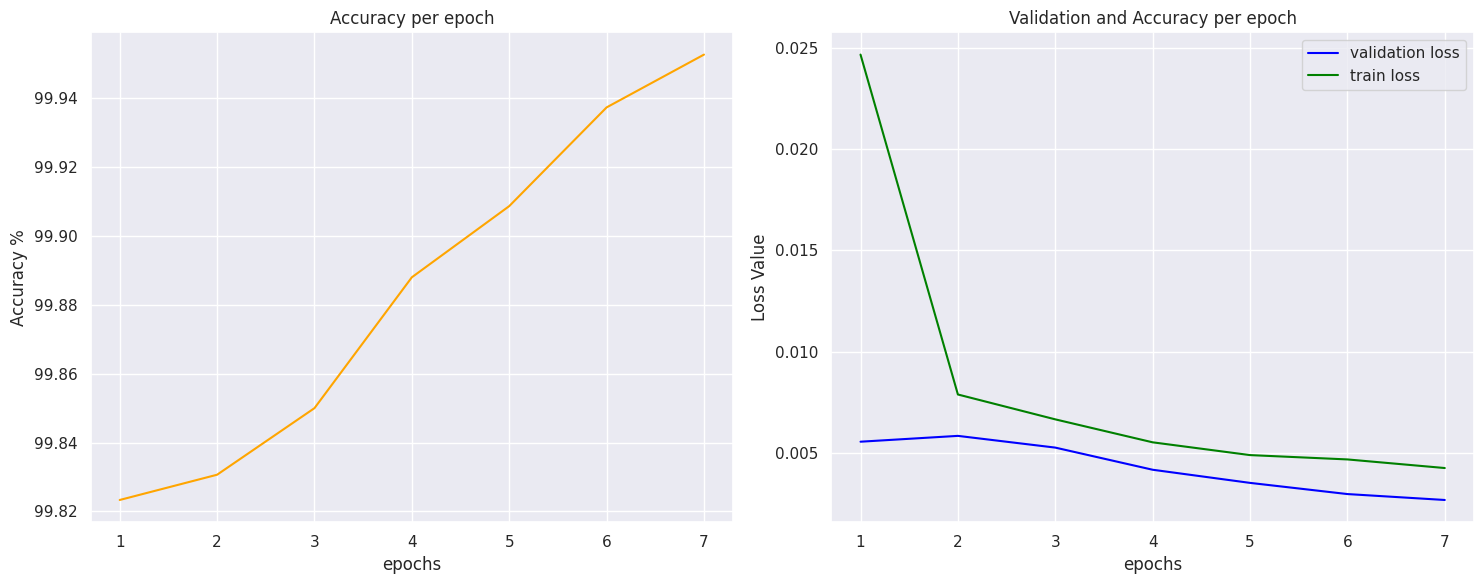

In [21]:
# plotting
sb.set_theme(style='darkgrid')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sb.lineplot(ax=ax[0], data=df, x='epoch', y='accuracy', markers='*', color='orange')
ax[0].set_title('Accuracy per epoch')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Accuracy %')

sb.lineplot(ax=ax[1], data=df, x='epoch', y='val_loss', markers='^', color='blue', label='validation loss')
sb.lineplot(ax=ax[1], data=df, x='epoch', y='train_loss', markers='*', color='green', label='train loss')
ax[1].set_title('Validation and Accuracy per epoch')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Loss Value')

plt.tight_layout()
plt.show();

In [22]:
tX_test = torch.tensor(X_test_pca, dtype=torch.float32)
model.to('cuda')

tX_test = tX_test.to('cuda')

model.eval()

with torch.no_grad():
    predictions = model(tX_test)
probabilities = torch.softmax(predictions, dim=1)
predicted_labels = torch.max(probabilities, 1)[1]

probabilities_np = probabilities.cpu().numpy()
predicted_labels_np = predicted_labels.cpu().numpy()


In [23]:
YLab = [f'{i}/{s}' for i, s in enumerate('walking walking_upstairs walking_downstairs sitting standing laying'.split())]  # column labels
pd.DataFrame(probabilities_np[:3,:], columns=YLab).style.background_gradient(cmap='coolwarm', axis=1)  # display first few predictions

,0/walking,1/walking_upstairs,2/walking_downstairs,3/sitting,4/standing,5/laying
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [24]:
result = pd.DataFrame(predicted_labels_np + 1, columns=['y']) # labels are shifted to the initial state
result.T

,0,1,2,3,4,5,6,7,8,9,...,2937,2938,2939,2940,2941,2942,2943,2944,2945,2946
y,1,6,6,2,1,6,2,6,1,5,...,2,1,3,2,4,5,6,3,4,2


In [25]:
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals
ToCSV(result, 'result') # generate a CSV submission file

In [26]:
tmr.stop()

time elapsed:  225.5035 seconds
